## 1. Load and Preprocess Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
df = pd.read_csv("./citibike_2023_cleaned.csv")
df = df.drop(columns=["end_hour", "end_minute"])
df["distance"] = np.sqrt((df["end_lat"] - df["start_lat"])**2 + (df["end_lng"] - df["start_lng"])**2) * 100.
df.head(5)

,rideable_type,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,month,day,start_hour,start_minute,trip_duration,distance
0,classic_bike,Walton Ave & E 168 St,Icahn Stadium,40.836655,-73.918324,40.793460,-73.923890,member,6,25,6,44,17.933333,4.355229
1,classic_bike,Grand Army Plaza & Central Park S,2 Ave & E 72 St,40.764004,-73.973974,40.768762,-73.958408,member,8,15,18,5,6.483333,1.627756
2,classic_bike,Knickerbocker Ave & Thames St,Melrose St & Broadway,40.705446,-73.929975,40.697481,-73.935877,casual,7,5,15,0,6.100000,0.991342
3,classic_bike,DeKalb Ave & Vanderbilt Ave,Pacific St & Classon Ave,40.689425,-73.968898,40.679194,-73.958790,member,3,5,11,29,7.566667,1.438156
4,classic_bike,Liberty St & Broadway,West Thames St,40.708164,-74.010369,40.708347,-74.017134,member,10,17,15,2,4.283333,0.676785


In [ ]:
df_dev, df_test = train_test_split(df, test_size=0.2)

# Define transformation and correponding columns
oh_columns = ["rideable_type", "member_casual"]
oh_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
station_names = pd.concat([df_dev["start_station_name"], df_dev["end_station_name"]]).unique()[:, None]
n_stations = len(station_names)
station_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=n_stations) # extra integer for unknown stations

# Apply station encoding
station_encoder.fit(station_names)
df_dev[["start_station_name"]] = station_encoder.transform(df_dev[["start_station_name"]])
df_dev[["end_station_name"]] = station_encoder.transform(df_dev[["end_station_name"]])
df_test[["start_station_name"]] = station_encoder.transform(df_test[["start_station_name"]])
df_test[["end_station_name"]] = station_encoder.transform(df_test[["end_station_name"]])

# Apply one-hot encoding
new_features = oh_encoder.fit_transform(df_dev[oh_columns])
new_columns = oh_encoder.get_feature_names_out(oh_columns)
df_dev[new_columns] = new_features
df_dev = df_dev.drop(columns=oh_columns)

new_features = oh_encoder.transform(df_test[oh_columns])
df_test[new_columns] = new_features
df_test = df_test.drop(columns=oh_columns)

data = (df_dev, df_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(


## 2. Neural Network and Dataset

In [ ]:
class DurationNet(nn.Module):
    def __init__(self, n_stations, embedding_dim, n_st_features):
        super().__init__()

        self.start_station_embedding = nn.Embedding(n_stations, embedding_dim)
        self.end_station_embedding = nn.Embedding(n_stations, embedding_dim)

        self.input_dim = embedding_dim * 2 + n_st_features

        self.fc_layers = nn.Sequential(
            nn.Linear(self.input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
        )
        self.output_layers = nn.Sequential(
            nn.Linear(33, 4),
            nn.GELU(),
            nn.Linear(4, 1)
        )

    def forward(self, start_station, end_station, distance, st_features):
        start_embed = self.start_station_embedding(start_station)
        end_embed = self.end_station_embedding(end_station)

        x = torch.cat([start_embed, end_embed, st_features], dim=1)
        x = self.fc_layers(x)
        output = self.output_layers(torch.cat([x, distance], dim=1))
        return output

In [ ]:
class DurationDataset(Dataset):
    def __init__(self, data, split: str = "train", transform=None):
        assert split in ("train", "test")

        self.data = data[0] if split == "train" else data[1]
        features, target = self.data.drop(columns=["trip_duration"]), self.data["trip_duration"]

        self.start_station = features["start_station_name"]
        self.end_station = features["end_station_name"]
        self.distance = features["distance"]
        self.st_features = features.drop(columns=["start_station_name", "end_station_name", "distance"])

        self.st_features = self.st_features.to_numpy()
        self.start_station = self.start_station.to_numpy()
        self.end_station = self.end_station.to_numpy()
        if not isinstance(self.distance, pd.DataFrame):
            self.distance = self.distance.to_frame()
        self.distance = self.distance.to_numpy()
        if not isinstance(target, pd.DataFrame):
            target = target.to_frame()
        self.target = target.to_numpy();

        self.st_features = torch.tensor(self.st_features).to(torch.float32)
        self.start_station = torch.tensor(self.start_station).to(torch.long)
        self.end_station = torch.tensor(self.end_station).to(torch.long)
        self.distance = torch.tensor(self.distance).to(torch.float32)
        self.target = torch.tensor(self.target).to(torch.float32)
        self.transform = transform

        assert len(self.st_features) == len(self.target)

    def __len__(self) -> int:
        return len(self.st_features)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = (self.start_station[idx], self.end_station[idx], self.distance[idx],
            self.st_features[idx], self.target[idx])
        if self.transform:
            sample = self.transform(sample)

        return sample


## 3. Model Training

In [ ]:
train_dataset = DurationDataset(data=data, split="train")
test_dataset = DurationDataset(data=data, split="test")
train_loader = DataLoader(train_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

In [ ]:
model = DurationNet(n_stations=n_stations + 1, embedding_dim=4, n_st_features=13).cuda()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

In [ ]:
n_epochs = 10
train_losses, test_losses = [], []

for epoch in range(n_epochs):

    model.train()
    progress_bar = tqdm.tqdm(train_loader)
    running_losses = []
    for i, sample in enumerate(progress_bar):
        start_station, end_station, distance, st_features, target = sample
        start_station, end_station, distance, st_features, target = (start_station.cuda(), end_station.cuda(),
            distance.cuda(), st_features.cuda(), target.cuda())

        # Training step
        optimizer.zero_grad()
        output = model(start_station, end_station, distance, st_features)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_losses.append(loss.item())
        mean_loss = sum(running_losses)/len(running_losses)
        progress_bar.set_description(f"Loss: {mean_loss}")

    # Record train loss
    train_losses.append(mean_loss)

    model.eval()
    with torch.no_grad():
        running_losses = []
        for i, sample in enumerate(test_loader):
            start_station, end_station, distance, st_features, target = sample
            start_station, end_station, distance, st_features, target = (start_station.cuda(), end_station.cuda(),
                distance.cuda(), st_features.cuda(), target.cuda())

            # Eval step
            output = model(start_station, end_station, distance, st_features)
            loss = criterion(output, target)
            running_losses.append(loss.item())

        # Record test loss
        test_losses.append(sum(running_losses)/len(running_losses))
    print(f"test loss: {test_losses[-1]}")

# Save the model
torch.save(model.state_dict(), 'checkpoint_duration_model.pt')

Loss: 6.942474435806274: 100%|██████████| 6250/6250 [00:43<00:00, 145.19it/s]


test loss: 6.6165498717046285


Loss: 6.768549355125427: 100%|██████████| 6250/6250 [00:42<00:00, 147.42it/s]


test loss: 6.558174175554106


Loss: 6.734501720542908: 100%|██████████| 6250/6250 [00:42<00:00, 147.46it/s]


test loss: 6.523135554691346


Loss: 6.710331325378418: 100%|██████████| 6250/6250 [00:42<00:00, 147.16it/s]


test loss: 6.504382901823223


Loss: 6.687648345336914: 100%|██████████| 6250/6250 [00:42<00:00, 146.74it/s]


test loss: 6.502631753969101


Loss: 6.674438255195618: 100%|██████████| 6250/6250 [00:42<00:00, 146.80it/s]


test loss: 6.486120575906677


Loss: 6.659723441200256: 100%|██████████| 6250/6250 [00:42<00:00, 147.55it/s]


test loss: 6.47937470556297


Loss: 6.641120097846985: 100%|██████████| 6250/6250 [00:42<00:00, 146.76it/s]


test loss: 6.4982528056537046


Loss: 6.628377504463196: 100%|██████████| 6250/6250 [00:42<00:00, 147.91it/s]


test loss: 6.486186267013208


Loss: 6.60978196762085: 100%|██████████| 6250/6250 [00:42<00:00, 146.63it/s]


test loss: 6.490672787106807


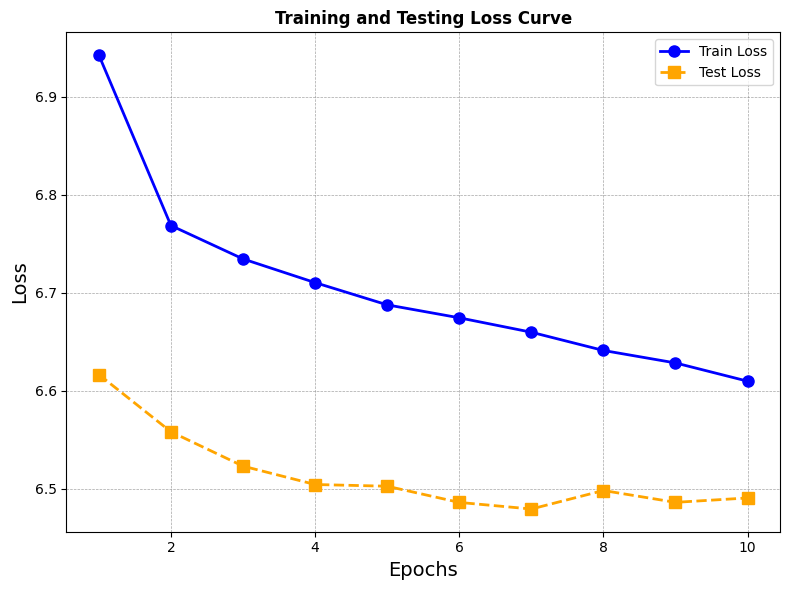

In [ ]:
# Plot train test loss curves
epochs = np.arange(1, n_epochs + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, label="Train Loss", marker='o', linestyle='-', linewidth=2, markersize=8, color='blue')
plt.plot(epochs, test_losses, label="Test Loss", marker='s', linestyle='--', linewidth=2, markersize=8, color='orange')

plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("Training and Testing Loss Curve", fontweight='bold')
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

## 4. Model Evaluation

In [ ]:
def compute_result(data_loader):
    predictions = np.array([])
    targets = np.array([])
    model.eval()
    with torch.no_grad():
        running_losses = []
        for i, sample in enumerate(test_loader):
            start_station, end_station, distance, st_features, target = sample
            start_station, end_station, distance, st_features, target = (start_station.cuda(), end_station.cuda(),
                distance.cuda(), st_features.cuda(), target.cuda())

            # Eval step
            output = model(start_station, end_station, distance, st_features)
            predictions = np.concatenate((predictions, output.cpu().numpy()[:, 0]))
            targets = np.concatenate((targets, target.cpu().numpy()[:, 0]))
    return predictions, targets

predictions, targets = compute_result(test_loader)
test_r2_score = r2_score(targets, predictions)
test_mae = np.abs(targets - predictions).mean()
print(f"R^2 Score on Test set: {test_r2_score:.4f}")
print(f"MAE on Test set: {test_mae:.4f}")

R^2 Score on Test set: 0.0608
MAE on Test set: 6.4901


In [ ]:
def get_report(y_pred, y_test):
    preds = np.concatenate([y_pred[:3], y_pred[-3:]])
    actuals = np.concatenate([y_test[:3], y_test[-3:]])
    df_compare = pd.DataFrame({'Prediction': preds,
                               'Actual': actuals})
    df_compare['Position'] = [1, 2, 3, len(y_pred) - 2, len(y_pred) - 1, len(y_pred)]
    df_compare = df_compare.set_index('Position')
    return df_compare

get_report(predictions, targets)

,Prediction,Actual
Position,,
1,6.580005,5.500000
2,8.045390,6.233333
3,16.692978,15.400000
199998,8.625553,8.950000
199999,13.113037,14.883333
200000,7.461846,7.583333
